In [1]:
import numpy as np
import argparse
import time
import os
from itertools import chain
import matplotlib.pyplot as plt
import multiprocessing as mp

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs
from sr_model.models.models import AnalyticSR, STDP_SR

## Collect the parameter range of interest
$$area=A\tau$$

In [2]:
def get_kernel_params(tau_0, A_0, tau_offset):
    area = A_0*tau_0
    new_tau = tau_0 + tau_offset
    new_A = area/new_tau
    return new_A, new_tau
    
def get_symm_kernel_params(tau_0, A_0, tau_offset):
    area = A_0*tau_0
    new_tau = tau_0 + tau_offset
    new_A = (area/2)/new_tau
    return new_A, new_tau

def get_stdp_kernel(
    A_pos, tau_pos, A_neg, tau_neg, kernel_len
    ):
    """ Returns plasticity kernel for plotting or debugging. """

    k = np.zeros(kernel_len)
    half_len = kernel_len//2
    scaling = 1
    k[:half_len] = scaling*A_neg * np.exp(
        np.arange(-half_len, 0)/tau_neg
        )
    k[-half_len-1:] = scaling*A_pos * np.exp(
        -1*np.arange(half_len+1)/tau_pos
        )
    return k

In [3]:
# Order: [A_pos, tau_pos, A_neg, tau_neg]
A_0 = 0.5
tau_0 = 1.15
set0 = get_kernel_params(tau_0, A_0, -0.5)
set1 = get_kernel_params(tau_0, A_0, -0.25)
set2 = get_kernel_params(tau_0, A_0, 0.5)
set3 = get_kernel_params(tau_0, A_0, 0.75)
set4 = get_symm_kernel_params(tau_0, A_0, -0)

params = [
    [A_0, tau_0, 0, 1],
    [set0[0], set0[1], 0, 1],
    [set1[0], set1[1], 0, 1],
    [set2[0], set2[1], 0, 1],
    [set3[0], set3[1], 0, 1],
    [set4[0], set4[1], set4[0], set4[1]],
    ]

errs = []

In [4]:
params

[[0.5, 1.15, 0, 1],
 [0.8846153846153847, 0.6499999999999999, 0, 1],
 [0.638888888888889, 0.8999999999999999, 0, 1],
 [0.34848484848484845, 1.65, 0, 1],
 [0.3026315789473684, 1.9, 0, 1],
 [0.25, 1.15, 0.25, 1.15]]

## Initialize data structures

In [5]:
device = 'cpu'

# Dataset Configs
dset = inputs.RBYCacheWalk(
    num_spatial_states=25*25,
    downsample_factor=None,
    skip_frame=0.7
    )

## Run through params

In [6]:
def eval_model(args):
    param = args
    
    net = STDP_SR(num_states=692, gamma=0.4)
    net.ca3.reset_trainable_ideal()
    net.ca3.set_differentiability(False)
    
    nn.init.constant_(net.ca3.A_pos, param[0])
    nn.init.constant_(net.ca3.tau_pos, param[1])
    nn.init.constant_(net.ca3.A_neg, param[2])
    nn.init.constant_(net.ca3.tau_neg, param[3])
    
    with torch.no_grad():
        dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
        dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
        _, outputs = net(dg_inputs, dg_modes, reset=True)
        est_T = net.ca3.get_T().detach().numpy()
        real_T = net.ca3.get_real_T()
        err = np.mean(np.abs(est_T - real_T))
        M0 = net.ca3.get_M_hat()
        M1 = net.ca3.get_M_hat(gamma=0.6)
    
    results = [param, M0, M1, err]
    return results

In [7]:
args_list = params

In [ ]:
def main():
    pool = mp.Pool(6)
    result = pool.map(eval_model, args_list)
    return result

In [ ]:
result = []
for args in args_list:
    result.append(eval_model(args))

In [29]:
import pickle
with open('evaled1.p', 'rb') as f:
    result = pickle.load(f)

## Plot Place Cells

In [30]:
from sr_model.plotting import SpatialPlot

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


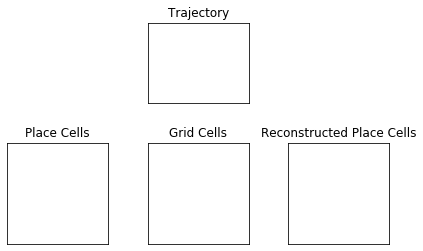

In [31]:
plotter = SpatialPlot(dset, 16, None, dset.sorted_states[:16], 'File')

In [36]:
def get_sr(T, gamma):                                                           
    D = np.diag(T @ np.ones(T.shape[0]))                                        
    P = np.linalg.inv(D) @ T                                                    
    M = np.linalg.pinv(np.eye(P.shape[0]) - gamma*P)                            
    return M  

In [39]:
result[2][1]

array([[1.0093000e-03, 2.4647710e-03, 2.5928870e-03, ..., 2.6468455e-03,
        1.0616810e-03, 2.3805869e-03],
       [2.3391667e-04, 2.6843224e-03, 6.6977111e-04, ..., 2.0235830e-03,
        3.8705967e-04, 2.8973331e-03],
       [5.0051702e-05, 8.5958804e-04, 1.6094074e-03, ..., 2.6235844e-03,
        1.2909303e-03, 1.4970086e-03],
       ...,
       [1.9850049e-03, 2.6857394e-03, 1.2643120e-03, ..., 2.1275231e-03,
        1.2879826e-03, 1.4488408e-03],
       [2.2230104e-03, 1.7071764e-03, 8.3114178e-04, ..., 2.4573833e-03,
        1.5500255e-03, 1.0167380e-04],
       [7.1749575e-09, 5.3032729e-09, 4.8074398e-09, ..., 2.9727003e-09,
        1.0066518e-08, 4.2838976e-01]], dtype=float32)

[0.5, 0.6499999999999999, 0.5, 0.6499999999999999]
9.862295817118135
Plotting T instead


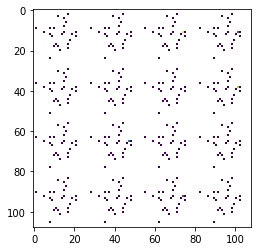

[0.5, 0.8999999999999999, 0.5, 0.8999999999999999]
0.00046442997240120197
Plotting T instead


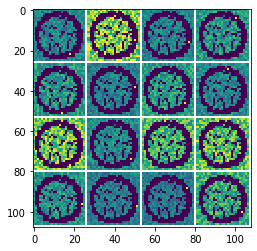

[0.5, 1.65, 0.5, 1.65]
0.24360122956793606
Plotting T instead


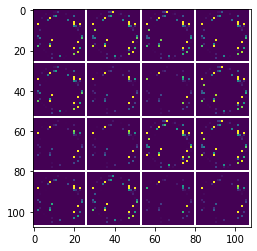

[0.5, 1.9, 0.5, 1.9]
1.6450441685451238
Plotting T instead


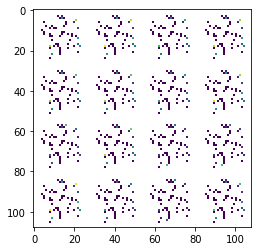

[0.5, 1.15, 0.5, 1.15]
0.04136581676532754
Plotting T instead


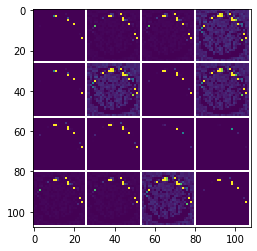

In [55]:
gamma = 0.4
for res in result:
    param, T, err = res
    print(param)
    print(err)
    try:
        M = get_sr(T, gamma)
        M[M < 0] = 0
    except:
        print("Plotting T instead")
        M = np.eye(T.shape[0])
        for step in np.arange(1,15):
            M += gamma**step + np.linalg.matrix_power(T, step)
        M[M < 0] = 0
    heatmap = plotter._format_into_heatmap(M)
    plt.figure()
    plt.imshow(heatmap)
    plt.show()

In [74]:
import pickle
with open('evaled3.p', 'rb') as f:
    result = pickle.load(f)

[0.1, 0.6499999999999999, 0.1, 0.6499999999999999]
0.0007465580772870059
Plotting T instead


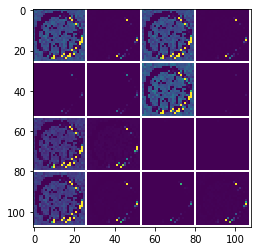

[0.1, 0.8999999999999999, 0.1, 0.8999999999999999]
0.0004991186750296793
Plotting T instead


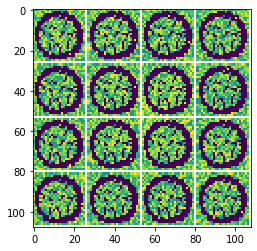

[0.1, 1.65, 0.1, 1.65]
0.126890248033202
Plotting T instead


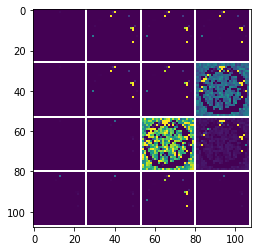

[0.1, 1.9, 0.1, 1.9]
0.08138585298706982
Plotting T instead


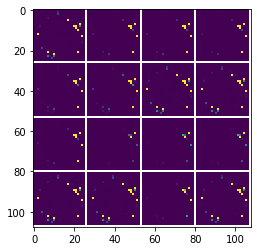

[0.1, 1.15, 0.1, 1.15]
1006.777217193834
Plotting T instead


/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


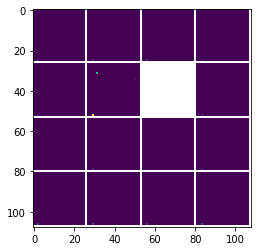

In [75]:
gamma = 0.5
for res in result:
    param, T, err = res
    print(param)
    print(err)
    try:
        M = get_sr(T, gamma)
        M[M < 0] = 0
    except:
        print("Plotting T instead")
        M = np.eye(T.shape[0])
        for step in np.arange(1,10):
            M += gamma**step + np.linalg.matrix_power(T, step)
        M[M < 0] = 0
        #M = T
    heatmap = plotter._format_into_heatmap(M)
    plt.figure()
    plt.imshow(heatmap)
    plt.show()

[0.1, 0.6499999999999999, 0.1, 0.6499999999999999]
1.5037141


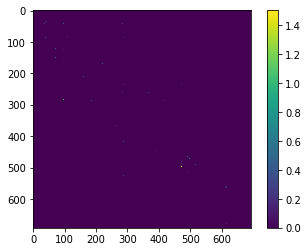

[0.1, 0.8999999999999999, 0.1, 0.8999999999999999]
0.0031104253


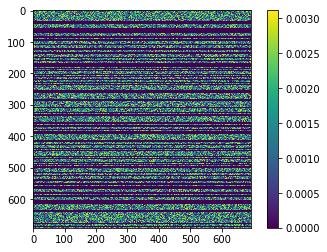

[0.1, 1.65, 0.1, 1.65]
4751.441


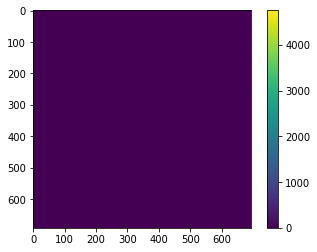

[0.1, 1.9, 0.1, 1.9]
626.0236


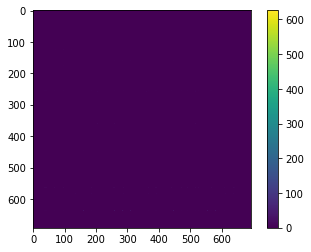

[0.1, 1.15, 0.1, 1.15]
56092360.0


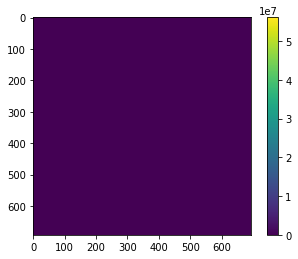

In [76]:
gamma = 0.5
for res in result:
    param, T, err = res
    print(param)
    print(T.max())
    plt.figure()
    plt.imshow(T)
    plt.colorbar()
    plt.show()